## Imports 

In [1]:
import numpy as np
import pandas as pd

# Import the Generator class
from bioverse.generator import Generator
from bioverse.survey import TransitSurvey
# from bioverse import util

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
# %matplotlib osx
%matplotlib inline

plt.rcParams['font.size'] = 20.

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 200
pd.options.display.max_columns = 80

figdir = '~/repos/magmaocean/src/tex/figures/'

# Sample generation

## Generate stars and planets, inject magma oceans

A fraction `f_magma` of planets are equipped with a global magma ocean, which reduce their radii. The probability of having a magma ocean is further dependent on the semimajor axis of the planet (as a proxy for irradiation by the host star).

For now, we model this dependence as a step function or an exponential decay in `a`.


In [171]:
# Parameters for star generation 
stars_args = {
# T_eff_max = 4000       # maximum stellar effective temperature in K to consider
'T_eff_split': 9700,     # Make sure there are some hotter stars as well (is this a bug that this is needed?)
'M_st_max' : 1.5,        # Maximum stellar mass to consider, in solar units.
'Mst_threshold' : 0.3,   # stellar mass threshold (i.e., 'what do we call "late"?')
'd_max' : 50,           # max. distance to stars in parsec
'seed' : 42              # seed for random number generators
} 

g_transit = Generator(label=None)
# g_transit.insert_step('create_stars_Gaia')
g_transit.insert_step('read_stars_Gaia')    # new version by KHU

# provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in stars_args.items()]

# Insert a function to the generator that labels late M dwarfs, defining a stellar mass threshold Mst_threshold.
# g_transit.insert_step(label_lateM)

stars = g_transit.generate(M_st_max=stars_args['M_st_max'], Mst_threshold=stars_args['Mst_threshold'])

# stars.to_pandas().M_st.hist()
# stars.M_st.hist()
# plt.xlabel('M_star')
# stars.to_pandas()
    

    
# ------------------------------------------------------
# Parameters for planet generation and magma ocean model
planets_args = {
'normalize_SpT': True, # Make sure occurrence rate is modulated with M_star
'optimistic' : True,   # If True, extrapolate the results of Mulders+2015 by assuming rocky planets are much more common around late-type M dwarfs. If False,
                       # assume that occurrence rates plateau with stellar mass for stars cooler than ~M3.
# 'transit_mode': True,  # Simulate only transiting planets
'transit_mode': False,  # Simulate only transiting planets?
    
# 'funform' : 'step',    # functional form of magma ocean probability aafo sma, either "exp_decay" or "step"
# 'funform' : 'exp_decay',    # functional form of magma ocean probability aafo sma, either "exp_decay" or "step"
# 'lambda_a' : 2.,       # "decay parameter" for semimajor axis dependency of P(magma ocean) (only needed for exponential decay functional form)
# 'f_magma' : .9,       # baseline fraction of planets with a magma ocean _within_ the magma ocean-relevant orbital distance
# 'a_cut': 0.5,          # cutoff sma for magma oceans
# 'radius_reduction': 0.1  # The fractional decrease of the planet's radius due to the global magma ocean.
'gh_increase' : True,  # wether or not to consider radius increase due to runaway greenhouse effect (Turbet+2020)
'water_incorp' : False, # wether or not to consider water incorporation in the melt of global magma oceans (Dorn & Lichtenberg 2021)
'wrr' : 0.01,           # water-to-rock ratio for Turbet+2020 model. Possible vals: 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05
}

g_transit.insert_step('create_planets_SAG13')
g_transit.insert_step('assign_orbital_elements')
g_transit.insert_step('impact_parameter')
g_transit.insert_step('assign_mass')
g_transit.insert_step('effective_values')

g_transit.insert_step('magma_ocean_NEW')     # here we inject the magma oceans

g_transit.insert_step('compute_transit_params')
# g_transit.insert_step('classify_planets')

# provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in planets_args.items()]

# save the generator
# g_transit.save('transit_magmaocean')


# show generator steps
g_transit

# Show parameters of a step: 
# g_transit.steps[-1]

Created a new Generator


Generator with 8 steps:
 0: Function 'read_stars_Gaia' with 10 keyword arguments.
 1: Function 'create_planets_SAG13' with 10 keyword arguments.
 2: Function 'assign_orbital_elements' with 2 keyword arguments.
 3: Function 'impact_parameter' with 1 keyword arguments.
 4: Function 'assign_mass' with no keyword arguments.
 5: Function 'effective_values' with no keyword arguments.
 6: Function 'magma_ocean_NEW' with 3 keyword arguments.
 7: Function 'compute_transit_params' with no keyword arguments.

In [172]:
# use this Generator object to produce an ensemble of planets within X parsecs:

sample = g_transit.generate()
# sample = sample.to_pandas()
# print("Generated a sample of {:d} planets including {:d} exo-Earth candidates.".format(len(sample), sample['EEC'].sum()))
print('Total number of planets: {}'.format(len(sample)))

Total number of planets: 172604


Keep only small planets/low-mass planets (Turbet+2020 goes only up to 2 Mearth)

In [173]:
# sample = sample[sample['R'] < 3.5]
sample = sample[sample['M'] < 2.]
print('Number of small planets: {}'.format(len(sample)))

Number of small planets: 72925


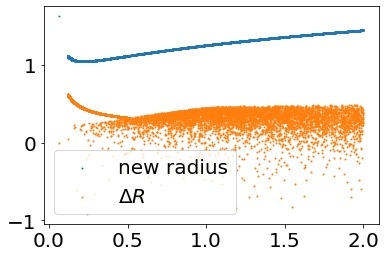

In [174]:
# check if M-R relation looks good:
d = sample.to_pandas()
mo = d[d.has_magmaocean]
plt.scatter(mo.M, mo.R, s=1., label='new radius')
plt.scatter(mo.M, mo.R - mo.R_orig, s=1., label='$\Delta R$')
plt.legend()

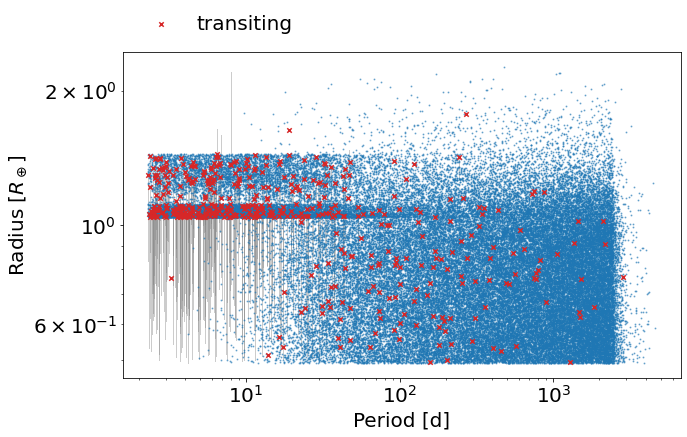

In [175]:
# show sample in period-radius:
sampledf = sample.to_pandas()
fig, ax = plt.subplots(figsize=[10, 6])
ax.scatter(sampledf[sampledf.transiting==False].P, sampledf[sampledf.transiting==False].R, s=1, alpha=.5)
ax.scatter(sampledf[sampledf.transiting==True].P, sampledf[sampledf.transiting==True].R, s=20, c='C3', marker='x', label='transiting')

# show differences in radius due to magma ocean
X_coords= np.array([sampledf[sampledf.transiting==True].P, sampledf[sampledf.transiting==True].P])
Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
ax.plot(X_coords, Y_coords, c='gray', lw=1., alpha=.4, zorder=-1)
        

ax.set_xlabel('Period [d]')
ax.set_ylabel('Radius [$R_\oplus$]')
ax.loglog()
ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
                              frameon=False, columnspacing=1.6)

In [176]:
# fig.savefig('/Users/schlecker/repos/magmaocean/src/tex/figures/synthetic_population.pdf', bbox_inches='tight')

### plot radius-sma dependency
Let's have a look at the sma dependence of planets bearing magma oceans:

In [177]:
from bioverse.hypothesis import magma_ocean_hypo_step, magma_ocean_f0, magma_ocean_hypo_exp
from bioverse.custom import magma_ocean
import scipy
def binned_stats(df, x_param, y_param, bins):
    means, edges, n = scipy.stats.binned_statistic(df[x_param], df[y_param], 
                                             statistic='mean', bins=bins)
    std = []
    for e_lo, e_hi in zip(edges[:-1], edges[1:]):
        std.append(np.std(df[(df[x_param] > e_lo) & (df[x_param] < e_hi)][y_param]))
    return means, edges, n, std


X = np.geomspace(0.005, 2., num=250)
R_avg = np.average(sample['R'])

P_magma = magma_ocean_hypo_step((planets_args['f_magma'], planets_args['a_cut'], 
                                 planets_args['radius_reduction'], R_avg), X)
# P_magma = magma_ocean_hypo_exp((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['lambda_a']), X)

P0 = magma_ocean_f0(R_avg, X)

plt.plot(X, P_magma, label='H (magma ocean)', lw=3)
plt.plot(X, P0, label='H_0')
plt.xscale('log')
plt.xlabel('Semi-major axis [au]',fontsize=15)
plt.ylabel('$<R_P>$',fontsize=15)


# sanity check to see if the function that assigns magma oceans is consistent with the hypothesis:
Xdf = pd.DataFrame([X,[R_avg for i in range(len(X))]], index=['a_eff', 'R']).T
Y = magma_ocean(Xdf, funform='step', f_magma=planets_args['f_magma'], a_cut=planets_args['a_cut'], radius_reduction=planets_args['radius_reduction'])
plt.scatter(Xdf.a_eff, Y.R, label='planets', s=2, c='k')

# plot binned stats as errorbar plot
means, edges, n, std = binned_stats(Y, 'a_eff', 'R', np.geomspace(np.min(Y['a_eff']), 2*np.max(Y['a_eff']), num=10))
# ax.hlines(np.mean(Y['R']), np.min(Y['a_eff']), np.max(Y['a_eff']), color='C2', label='mean $R_P$')
plt.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
           yerr=None, fmt='none', color='C6', label='binned $R_P$ statistic', elinewidth=2.5)


plt.legend(fontsize=12, loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
                              frameon=False, columnspacing=1.6)

KeyError: 'f_magma'

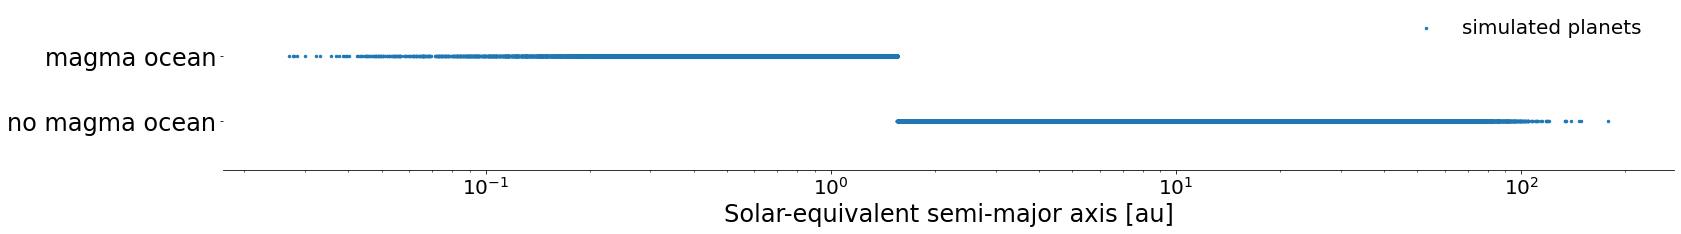

In [132]:
x, y = sample['a_eff'], sample['has_magmaocean']

# Now plot the water-rich/water-poor planets versus a_eff (in log-space)
fig, ax = plt.subplots(figsize=(26,3))
ax.scatter(x,y, s=6, label='simulated planets')
ax.set_xscale('log')
ax.set_yticks([0,1])
ax.set_yticklabels(['no magma ocean','magma ocean'],fontsize=24)
ax.set_xlabel('Solar-equivalent semi-major axis [au]',fontsize=24)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# To turn off the bottom or left
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(-.75, 1.75)
ax.legend(loc='lower right', ncol=99, bbox_to_anchor=(.99, .7),
                              frameon=False, columnspacing=1.6)
plt.show()

In [135]:
# fig.savefig('/Users/schlecker/repos/magmaocean/src/tex/figures/has_magmaocean.pdf', bbox_inches='tight')

### plot Phi(k) correlation between planets having a magma ocean and planets smaller than the mean of the population

In [136]:
import phik
from phik import resources, report

sample.to_pandas()[['is_small', 'has_magmaocean']].hist2d()

KeyError: "['is_small'] not in index"

In [137]:
sample.to_pandas()[['is_small', 'has_magmaocean']].phik_matrix()

KeyError: "['is_small'] not in index"

# Survey simulation

We have generated a population of synthetic planets that orbit synthetic stars and we have injected a statistical trend originating from the presence of magma oceans on some planets. Only a subset of these planets "will be detectable by a transit or direct imaging survey. For those planets, only a subset of their properties can be directly probed, and only with a finite level of precision."

In the following, we will simulate a transit survey and try to detect the (population-wide) effect on the planet radius caused by global magma oceans

## Define transit survey

let's define some key parameters of the survey: [TODO: check which ones are needed to define our transit surveys]
- ``diameter``: the diameter of the telescope primary in meters (or the area-equivalent diameter for a telescope array)
- ``t_max``: maximum amount of time across which to combine transit observations, in days
- ``N_obs_max``: maximum allowable number of transit observations per target
- ``t_slew``: slew time between observations, in days
- ``D_ref``: diameter of the reference telescope, in meters

e.g., we could choose values similar to the ones expected for the LIFE telescope array (LIFE collaboration, 2021). In the nominal configuration with four 2 m telescopes, it would have a equivalent light-collecting area of a 4 m telescope.

In [138]:
survey = TransitSurvey(diameter=8.5, t_max=3652.5, t_slew=0.1, N_obs_max=1000)
# survey = TransitSurvey(diameter=.5, t_max=3.6525, t_slew=0.1, N_obs_max=2)

Created a new TransitSurvey


Let's add some measurements our survey conducts. 'small_radius' is True for a planet if it has a radius smaller than the mean of the population.

In [139]:
margs = {}
mkeys = ['L_st', 'R_st', 'M_st', 'T_eff_st', 'd', 'age', 'depth', 'R', 'T_dur', 
         'P', 'a', 'a_eff', 'is_small', 'S', 'S_abs']

# GOOD survey: choose super-optimistic values for now.
margs['precision'] = {'T_eff_st': 25.,
                      'R_st': '1%',
                      'depth': '1%',
                      'R': '1%',
                      'M_st': '1%',
                      'age': '30%',
                      'P': 0.000001,
                      'S': '1%'}


# # BAD survey: choose rather modest survey performance.
# margs['precision'] = {'T_eff_st': 75.,
#                       'R_st': '20%',
#                       'depth': '20%',
#                       'R': '20%',
#                       'M_st': '30%',
#                       'age': '75%',
#                       'P': 0.01,
#                       'S': '20%'}




# Add the measurements to s_transit
for mkey in mkeys:
    kwargs = {}
    for key, vals in margs.items():
        if mkey in vals:
            kwargs[key] = vals[mkey]
    survey.add_measurement(mkey, **kwargs)
# survey

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


which planets are detectable?

In [140]:
detected = survey.compute_yield(sample)
N = len(detected)
print(N)

913


simulate observations, obtain dataset

In [141]:
data = survey.observe(detected)
data.to_pandas().head()


Could not measure property: is_small


,planetID,starID,L_st,R_st,M_st,T_eff_st,d,age,depth,R,T_dur,P,a,a_eff,S,S_abs
0,77,5,0.00169,0.173994,0.143420,2792.957553,2.72,8.123452,0.009398,1.818823,0.063321,18.885334,0.072239,1.757217,0.325077,220.220576
1,98,7,0.00211,0.171551,0.139496,2975.792577,3.16,5.819519,0.003982,1.185739,0.241798,748.672336,0.837883,18.240721,0.002937,2.043736
2,291,30,0.00123,0.143019,0.114048,2932.228062,4.66,9.527027,0.003035,0.839629,0.071072,48.085925,0.125117,3.567508,0.079786,53.429242
3,461,54,0.00385,0.216337,0.176602,3197.792965,5.91,2.770861,0.012559,2.571633,0.139539,87.734500,0.217776,3.509783,0.083011,55.201178
4,515,64,0.00071,0.126388,0.099171,2763.580034,6.36,5.555341,0.025499,2.194809,0.065246,58.645611,0.137121,5.146048,0.037645,25.677999


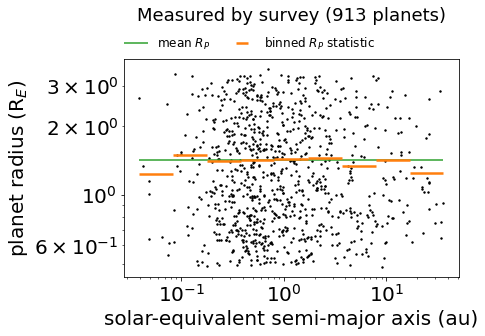

In [142]:
fig, ax = plt.subplots()
ax.scatter(data['a_eff'], data['R'], s=2, c='k')
ax.set_xscale('log')
ax.set_yscale('log')



# plot binned stats as errorbar plot
means, edges, n, std = binned_stats(data, 'a_eff', 'R', np.geomspace(np.min(data['a_eff']), np.max(data['a_eff']), num=10))
ax.hlines(np.mean(data['R']), np.min(data['a_eff']), np.max(data['a_eff']), color='C2', label='mean $R_P$')
ax.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
           yerr=None, fmt='none', color='C1', label='binned $R_P$ statistic', elinewidth=2.5)


ax.set_ylabel('planet radius (R$_E$)')
ax.set_xlabel('solar-equivalent semi-major axis (au)')
ax.set_title('Measured by survey ({} planets)'.format(N), y=1.15, fontsize=18)
fig.legend(fontsize=12, loc='lower left', ncol=99, bbox_to_anchor=(0.1, .87),
                              frameon=False, columnspacing=1.6)

# Hypothesis tests 

## Define Hypotheses
These assume a specific functional form

In [143]:
from bioverse.hypothesis import Hypothesis, magma_ocean_hypo_step, magma_ocean_hypo_exp,magma_ocean_f0, f_null

params = ('f_magma', 'a_cut', 'radius_reduction', 'R_avg')    # for step function
# params = ('f_magma', 'a_cut', 'lambda_a')   # for exp. decay
features = ('a_eff',)
labels = ('R',)

# define priors for the parameters in theta (uniform for f_magma, radius_reduction, 'R_avg'; log-uniform for a_cut)
bounds = np.array([[0.001, 1.0], [0.01, 10.], [0.005, 1.], [0.1, 13.]])
log = (False, True, False, False)
# bounds = np.array([[0.001, 1.0], [0.01, 10.], [0.005, 4.]]) # for exp decay
# log = (False, True, False) # for exp decay


# define hypothesis
h_magmaocean = Hypothesis(magma_ocean_hypo_step, bounds, params=params, features=features, labels=labels, log=log)
# h_magmaocean = Hypothesis(magma_ocean_hypo_exp, bounds, params=params, features=features, labels=labels, log=log)

# define null hypothesis: a broad distribution in planet radius that is independent of orbital distance
bounds_null = np.array([[0.01, 13.]])
h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(True,))

## Perform hypothesis testing 

Sample posterior; Calculate the Bayesian evidence supporting h_magmaocean in favor of h_null from our simulated dataset.

The parameter space is complex, need to use nested sampling (not MCMC).

In [ ]:
%%time

import corner

# Sample the posterior distribution of h(theta | x, y) using a simulated data set, and compare to the null hypothesis via a model comparison metric.
results = h_magmaocean.fit(data, return_chains=True, nburn=100, nlive=200)
 
print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.3f})".format(
    results['dlnZ'], np.exp(-results['dlnZ'])))

The evidence in favor of the hypothesis is: dlnZ = 8080.7 (corresponds to p = 0.000)
CPU times: user 22.2 s, sys: 1.26 s, total: 23.5 s
Wall time: 23.2 s


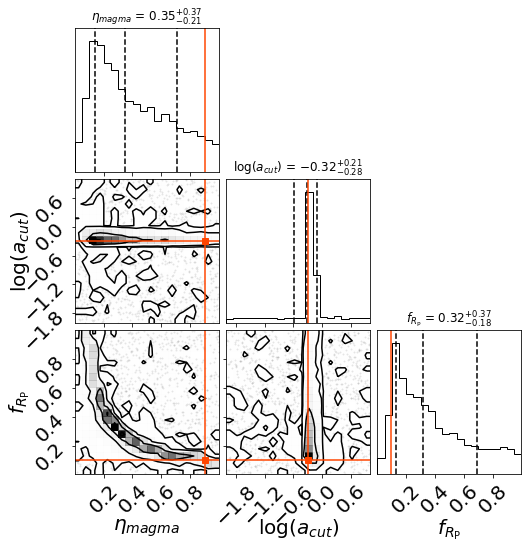

In [ ]:
# turn into DataFrame, make logged columns for params with log priors
chains = pd.DataFrame(results['chains'], columns=params)
for p, l in zip(params, log):
    if l:
        chains['log_' + p] = np.log10(chains[p])

fig = corner.corner(
                    chains[['f_magma', 'log_a_cut', 'radius_reduction']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$'],
                    # chains[['f_magma', 'log_a_cut', 'lambda_a']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$\lambda_a$'],
                    # chains[['f_magma', 'log_a_cut', 'radius_reduction','R_avg']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$', 'R$_{avg}$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12},
                    truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['radius_reduction']], truth_color='orangered'
                    # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['lambda_a']], truth_color='orangered'
                    # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['radius_reduction'], R_avg], truth_color='orangered'
                    )

fig.set_facecolor('white')

# Statistical Power
Test sensitivity on Poisson uncertainty, e.g. the specific realization of a survey.

In [50]:
%%time

from bioverse import analysis

# Repeat the hypothesis test for different magma ocean parameter values
radius_reduction_grid = np.linspace(0.0, .9, 6)
results = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, radius_reduction=radius_reduction_grid, N=10, f_magma=0.9, processes=8)

# Determine the statistical power assuming a significance threshold of dlnZ > 3
power = analysis.compute_statistical_power(results, method='dlnZ', threshold=3)
print("The statistical power of the survey is {:.1f}%".format(100*power))

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 56/60 [02:38<00:11,  2.83s/it]


Interrupted, terminating remaining processes



multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/schlecker/repos/Bioverse/bioverse/analysis.py", line 105, in test_hypothesis_grid_iter
    sample, detected, data = survey.quickrun(generator, **kwargs)
  File "/Users/schlecker/repos/Bioverse/bioverse/survey.py", line 121, in quickrun
    sample = generator.generate(**kwargs)
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 130, in generate
    self.update_steps()
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 71, in update_steps
    step.load_function(reload=reload)
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 265, in load_function
    func = util.import_function_from_file(self.function_name, ROOT_DIR+'/'+self.filename)
  File "/Users/schlecker/repos/Bioverse/bioverse/util.py", line 88, in

TypeError: unsupported format string passed to numpy.ndarray.__format__

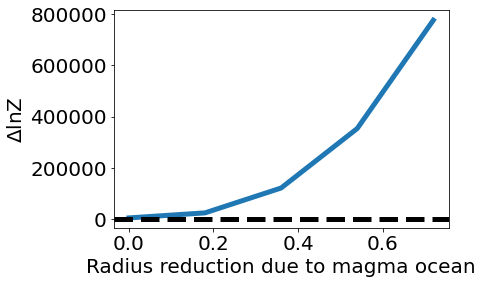

In [ ]:
plt.plot(radius_reduction_grid, results['dlnZ'].mean(axis=-1), lw=5)
plt.xlabel('Radius reduction due to magma ocean', fontsize=20)
plt.ylabel('$\Delta$lnZ', fontsize=20)
plt.axhline(3, lw=5, c='black', linestyle='dashed')
# plt.xscale('log')


# plt.loglog()


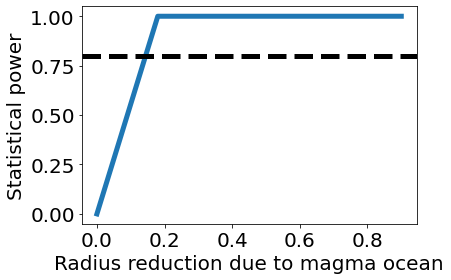

In [527]:
# Determine the statistical power assuming a significance threshold of dlnZ > 3
power = analysis.compute_statistical_power(results, method='dlnZ', threshold=3)
# power = analysis.compute_statistical_power(results, method='logp')

plt.plot(radius_reduction_grid, power, lw=5)
plt.xlabel('Radius reduction due to magma ocean', fontsize=20)
plt.ylabel('Statistical power', fontsize=20)
plt.axhline(.8, lw=5, c='black', linestyle='dashed')
# plt.xscale('log')